In [60]:
from scipy.interpolate import interp1d
from specutils import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from specutils.manipulation import FluxConservingResampler
from pybaselines import whittaker
import numpy as np
import matplotlib.pyplot as plt
import pickle
import astropy.units as u
from astropy.io import fits
import scipy.constants as cst
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.cosmology import Planck15 as cosmo
from functools import partial
import powspec
import pandas as pd
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.modeling.models import Gaussian1D
from scipy.interpolate import interp1d
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
from astropy.wcs import WCS
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers


#noise_model_HF = pd.read_csv('tim_sw_loading.tsv', sep='\t')
#noise_model_LF = pd.read_csv('tim_lw_loading.tsv', sep='\t')

/tmp/ipykernel_15886/1656415542.py:23: RuntimeWarning: divide by zero encountered in divide
  def w_to_f(x): return cst.c/(x*1e9)/1e-6


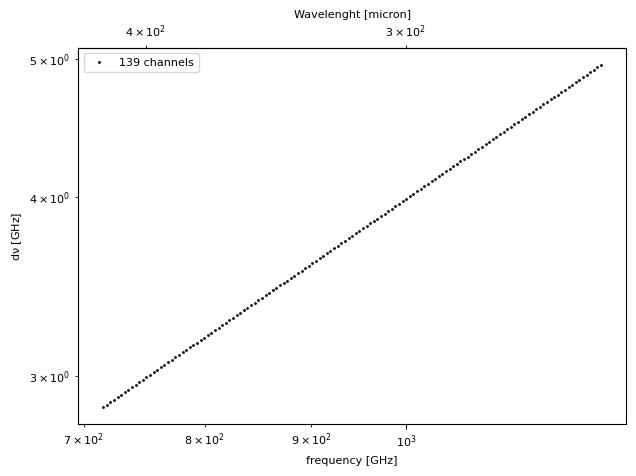

In [61]:
# Parameters
nu_min = 715e9   # Hz
nu_max = 1250e9  # Hz
R = 250

# Logarithmic step in frequency
dlognu = np.log(1 + 1 / R)

# Generate log-frequency array
log_nu_min = np.log(nu_min)
log_nu_max = np.log(nu_max)

n_channels = int(np.floor((log_nu_max - log_nu_min) / dlognu))  # number of channels

# Log-frequency centers
log_nus = log_nu_min + dlognu * np.arange(n_channels)
nu_centers = np.exp(log_nus)  # back to Hz

fig, ax = plt.subplots()
ax.loglog(nu_centers/1e9, nu_centers*dlognu/1e9, 'ok', markersize=1, label=f'{len(nu_centers)}'+' channels')
ax.set_xlabel('frequency [GHz]')
ax.set_ylabel('d$\\rm \\nu$ [GHz]')
def w_to_f(x): return cst.c/(x*1e9)/1e-6
secax = ax.secondary_xaxis("top", functions=(w_to_f,w_to_f))
secax.set_xlabel('Wavelenght [micron]')
ax.legend()
plt.tight_layout()

In [62]:
zcii_tim = 1900.53690000e9 / (nu_centers) -1

#Spatial deep
res = 40 #arcsec
field_size_ra =  0.2 #deg
field_size_dec = 1 #deg
field_size = field_size_dec * field_size_ra

In [63]:
Dc_center = cosmo.comoving_distance(zcii_tim).value
center = Dc_center.mean()
D_M_center = cosmo.comoving_transverse_distance(zcii_tim)
Delta_Dc = cst.c*1e-3*(1+zcii_tim) / cosmo.H(zcii_tim).value * nu_centers*dlognu / nu_centers
size_x = (np.radians(field_size_ra)  * D_M_center).to(u.Mpc).value  # Mpc
size_y = (np.radians(field_size_dec) * D_M_center).to(u.Mpc).value  # Mpc

V = size_x * size_y * Delta_Dc 

len_pix = ((np.radians(res/3600) * D_M_center).to(u.Mpc).value)
vox_V= len_pix**2 * Delta_Dc

npix_x = size_x / len_pix
npix_y = size_y / len_pix

In [64]:
# Number of pixels along each axis
n_x = int(np.ceil((np.radians(field_size_ra) /np.radians(res/3600))))
n_y = int(np.ceil((np.radians(field_size_dec)/np.radians(res/3600))))

# Transverse Mpc per pixel (using the center redshift distance)
pix_scale_x = size_x / n_x  # Mpc
pix_scale_y = size_y / n_y  # Mpc

# Transverse axes (x and y) centered on zero
x = (np.arange(n_x) - n_x//2) * pix_scale_x[:, None]
y = (np.arange(n_y) - n_y//2) * pix_scale_y[:, None]
z = Dc_center-center

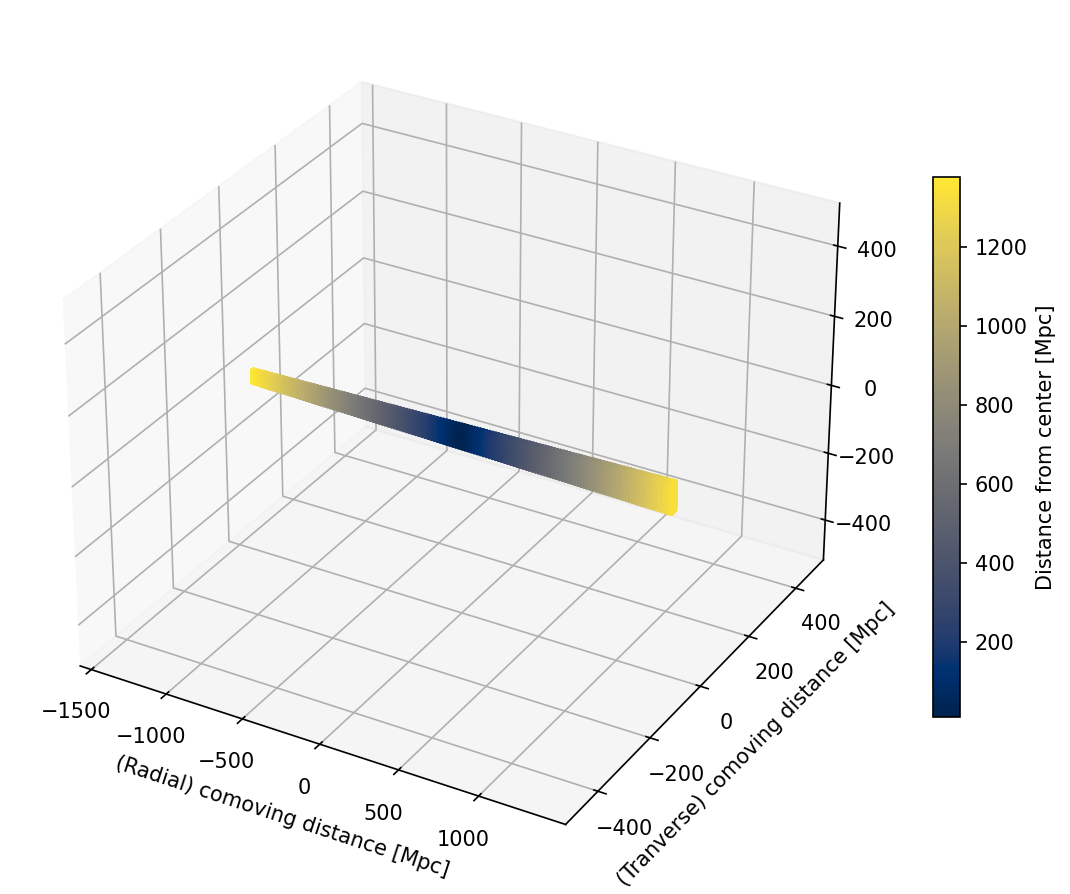

In [65]:
#2. Use broadcasting shapes directly:
X = x[:, None, :]            # shape (30, 1, 1)
Y = y[:, :, None]            # shape (1, 20, 1)
Z = z[:,None,None]            # shape (1, 1, 25)

# 3. Compute R using broadcasting (shape: 30×20×25)
R = np.sqrt(Z**2+X**2 + Y**2)

# 4. Flatten all to 1D arrays of same length
xv = np.broadcast_to(X, R.shape).ravel()
yv = np.broadcast_to(Y, R.shape).ravel()
zv = np.broadcast_to(Z, R.shape).ravel()
rv = R.ravel()

# 5. Plot
BS=10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 

fig = plt.figure(figsize=(7.5,7.5), dpi=150)
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(zv, xv, yv, c=rv, cmap='cividis', s=1, )
ax.set_xlabel("(Radial) comoving distance [Mpc]")
ax.set_ylabel("(Tranverse) comoving distance [Mpc]")
colorbar = plt.colorbar(sc, ax=ax, shrink=0.5)
colorbar.set_label("Distance from center [Mpc]")
ax.set_ylim([-500, 500])  # Example limits for y-axis
ax.set_zlim([-500, 500])  # Example limits for z-axis
fig.tight_layout()

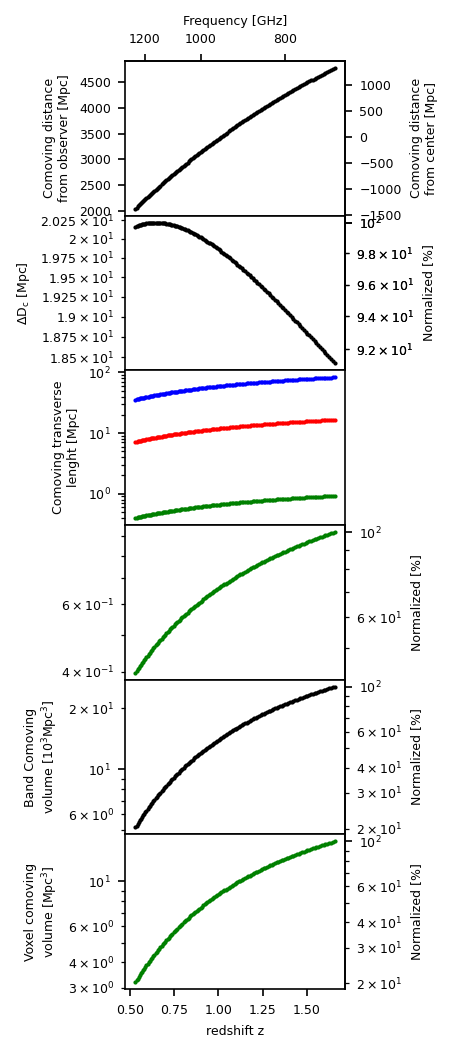

In [66]:
BS=6; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 
fig, axs = plt.subplots(6,figsize=(3,7),sharex=True,dpi=150)
axa,axb,axc,axf,axd,axe = axs

def z_to_f(nu_rest,x): return nu_rest/(1+x) / 1e9
F = partial(z_to_f,1900.53690000e9)
secax = axs[0].secondary_xaxis("top", functions=(F,F))
secax.set_xlabel('Frequency [GHz]')
axs[-1].set_xlabel('redshift z')

axa.plot(zcii_tim, Dc_center, 'ok', markersize=1)
def centering(center,x): return x-center
F = partial(centering,center)
secax = axa.secondary_yaxis("right", functions=(F,F))
secax.set_ylabel('Comoving distance\nfrom center [Mpc]')
axa.set_ylabel('Comoving distance\nfrom observer [Mpc]')

def centering(max,x): return x/max*100
F = partial(centering, Delta_Dc.max())
secax = axb.secondary_yaxis("right", functions=(F,F))
def centering(max,x): return x/max*100
F = partial(centering, Delta_Dc.max())
secax = axb.secondary_yaxis("right", functions=(F,F))
axb.plot(zcii_tim, Delta_Dc, 'ok', markersize=1)
axb.set_ylabel('$\\rm \\Delta D_c$ [Mpc]')
secax.set_ylabel('Normalized [%]')

axc.plot(zcii_tim, size_x, 'or', markersize=1)
axc.plot(zcii_tim, size_y, 'ob', markersize=1)
axc.plot(zcii_tim, len_pix, 'og', markersize=1)

axc.set_ylabel('Comoving transverse\nlenght [Mpc]')

axf.plot(zcii_tim, len_pix, 'og', markersize=1)
def centering(max,x): return x/max*100
F = partial(centering, len_pix.max())
secax = axf.secondary_yaxis("right", functions=(F,F))
secax.set_ylabel('Normalized [%]')


axd.plot(zcii_tim,V/1e3,'ok', markersize=1)
def centering(max,x): return x/max*100
F = partial(centering, V.max()/1e3)
secax = axd.secondary_yaxis("right", functions=(F,F))
secax.set_ylabel('Normalized [%]')
axd.set_yscale('log')
axd.set_ylabel('Band Comoving\nvolume [$\\rm 10^3 Mpc^3$]')

axe.plot(zcii_tim, vox_V,'og', markersize=1)
axe.set_yscale('log')
axe.set_ylabel('Voxel comoving\nvolume [$\\rm Mpc^3$]')

def centering(max,x): return x/max*100
F = partial(centering, vox_V.max())
secax = axe.secondary_yaxis("right", functions=(F,F))
secax.set_ylabel('Normalized [%]')

for ax in axs[1:]: ax.set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)

/tmp/ipykernel_15886/3343326849.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


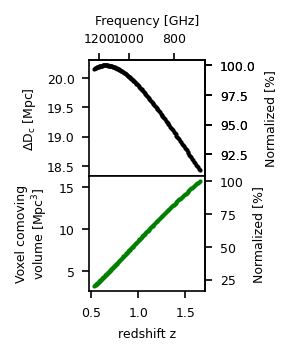

In [67]:
BS=6; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 
fig, axs = plt.subplots(2,figsize=(1,2),sharex=True,dpi=150)
axb,axe= axs

def z_to_f(nu_rest,x): return nu_rest/(1+x) / 1e9
F = partial(z_to_f,1900.53690000e9)
secax = axs[0].secondary_xaxis("top", functions=(F,F))
secax.set_xlabel('Frequency [GHz]')
axs[-1].set_xlabel('redshift z')

def centering(max,x): return x/max*100
F = partial(centering, Delta_Dc.max())
secax = axb.secondary_yaxis("right", functions=(F,F))
def centering(max,x): return x/max*100
F = partial(centering, Delta_Dc.max())
secax = axb.secondary_yaxis("right", functions=(F,F))
axb.plot(zcii_tim, Delta_Dc, 'ok', markersize=1)
axb.set_ylabel('$\\rm \\Delta D_c$ [Mpc]')
secax.set_ylabel('Normalized [%]')


axe.plot(zcii_tim, vox_V,'og', markersize=1)
axe.set_yscale('log')
axe.set_ylabel('Voxel comoving\nvolume [$\\rm Mpc^3$]')
def centering(max,x): return x/max*100
F = partial(centering, vox_V.max())
secax = axe.secondary_yaxis("right", functions=(F,F))
secax.set_ylabel('Normalized [%]')

for ax in axs[1:]: ax.set_yscale('linear')

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)

# With the real cube

In [68]:
path = '/home/mvancuyck/Desktop/LIM_and_foregrounds/cubes/'
ciifile = path+"pySIDES_from_uchuu_TIM_tile0_1.414deg_1.414deg_res30arcsec_R250.0_CII_de_Looze_nobeam_MJy_sr.fits"
fullfile = path+"pySIDES_from_uchuu_TIM_tile0_1.414deg_1.414deg_res30arcsec_R250.0_full_de_Looze_nobeam_MJy_sr.fits"
alllinesfille = path+"pySIDES_from_uchuu_TIM_tile0_1.414deg_1.414deg_res30arcsec_R250.0_all_lines_de_Looze_nobeam_MJy_sr.fits"
contfile = path+"pySIDES_from_uchuu_TIM_tile0_1.414deg_1.414deg_res30arcsec_R250.0_continuum_nobeam_MJy_sr.fits"

cii = fits.getdata(ciifile)*1e3
hdr = fits.getheader(ciifile)
cont = fits.getdata(contfile)*1e3

with fits.open(ciifile) as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

wcs = WCS(header) 

In [69]:
# Dimensions of cut in pixels
N_RA = int(1.4 / 0.0083333)    
N_DEC = int(1.4 / 0.0083333)     

# Center pixel
center_RA = hdr['NAXIS1'] // 2   
center_DEC = hdr['NAXIS2'] // 2  

# Pixel ranges
ra_min = center_RA - N_RA // 2
ra_max = center_RA + N_RA // 2

dec_min = center_DEC - N_DEC // 2
dec_max = center_DEC + N_DEC // 2

# Assuming your data cube is called "cube" with shape (Nfreq, Ndec, Nra)
subcube_cii = cii[:, dec_min:dec_max, ra_min:ra_max]
subcube_cont = cont[:, dec_min:dec_max, ra_min:ra_max]

In [70]:
z_index = np.arange(0,header['NAXIS3'],1)
frequencies = np.exp(wcs.swapaxes(0, 2).sub(1).wcs_pix2world(z_index, 0)[0]) / 1e9
dlognu = hdr['CDELT3']
zcii = 1900.53690000 / frequencies -1
Dc_center = cosmo.comoving_distance(zcii).value
center = Dc_center.mean()
D_M_center = cosmo.comoving_transverse_distance(zcii)
Delta_Dc = cst.c*1e-3*(1+zcii) / cosmo.H(zcii).value * frequencies*dlognu / frequencies

#Spatial deep
res =(hdr['CDELT2']*u.Unit(hdr['CUNIT2'])).to(u.deg).value
size_RA = (N_RA * hdr['CDELT1']*u.Unit(hdr['CUNIT2'])).to(u.deg).value
size_DEC = (N_DEC * hdr['CDELT2']*u.Unit(hdr['CUNIT2'])).to(u.deg).value
size_RA_corrected = size_RA * np.cos(np.radians(hdr['CRVAL2']))
size_x = (np.radians(size_RA)  * D_M_center).to(u.Mpc).value  # Mpc
size_y = (np.radians(size_DEC) * D_M_center).to(u.Mpc).value  # Mpc

# Number of pixels along each axis
n_x = N_RA #int(hdr['NAXIS2'])
n_y = N_DEC #int(hdr['NAXIS1'])

# Transverse Mpc per pixel (using the center redshift distance)
pix_scale_x = size_x / n_x  # Mpc
pix_scale_y = size_y / n_y  # Mpc

# Transverse axes (x and y) centered on zero
x = (np.arange(n_x) - n_x//2) * pix_scale_x[:, None]
y = (np.arange(n_y) - n_y//2) * pix_scale_y[:, None]
z = Dc_center-center

len_pix = ((np.radians(res) * D_M_center).to(u.Mpc).value)
vox_V= len_pix**2 * Delta_Dc

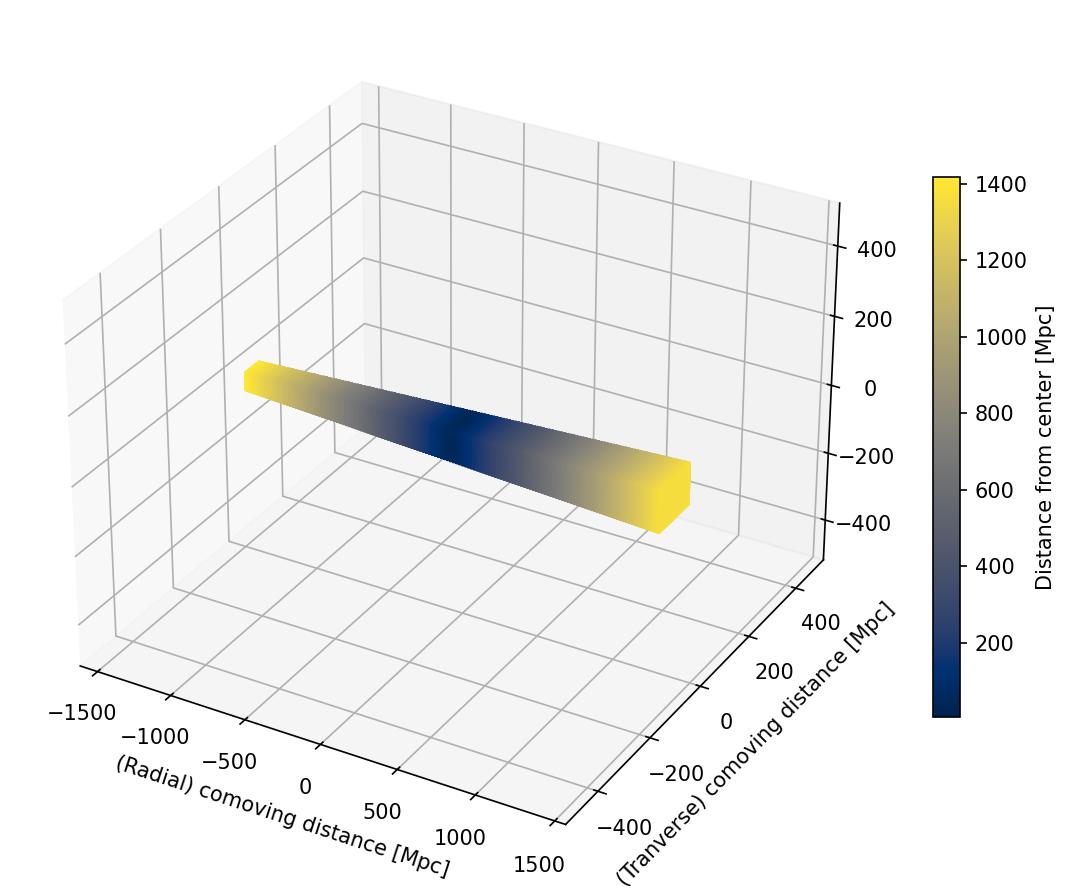

In [71]:
#2. Use broadcasting shapes directly:
X = x[:, None, :]            
Y = y[:, :, None]            
Z = z[:,None,None]           

# 3. Compute R using broadcasting
R = np.sqrt(Z**2+X**2+Y**2)

# 4. Flatten all to 1D arrays of same length
xv = np.broadcast_to(X, R.shape).ravel()
yv = np.broadcast_to(Y, R.shape).ravel()
zv = np.broadcast_to(Z, R.shape).ravel()
rv = R.ravel()

# 5. Plot
BS=10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 

fig = plt.figure(figsize=(7.5,7.5), dpi=150)
ax = fig.add_subplot(projection='3d')

sc = ax.scatter(zv, xv, yv, c=rv, cmap='cividis', s=1, )
ax.set_xlabel("(Radial) comoving distance [Mpc]")
ax.set_ylabel("(Tranverse) comoving distance [Mpc]")
colorbar = plt.colorbar(sc, ax=ax, shrink=0.5)
colorbar.set_label("Distance from center [Mpc]")
ax.set_ylim([-500, 500])  # Example limits for y-axis
ax.set_zlim([-500, 500])  # Example limits for z-axis
fig.tight_layout()

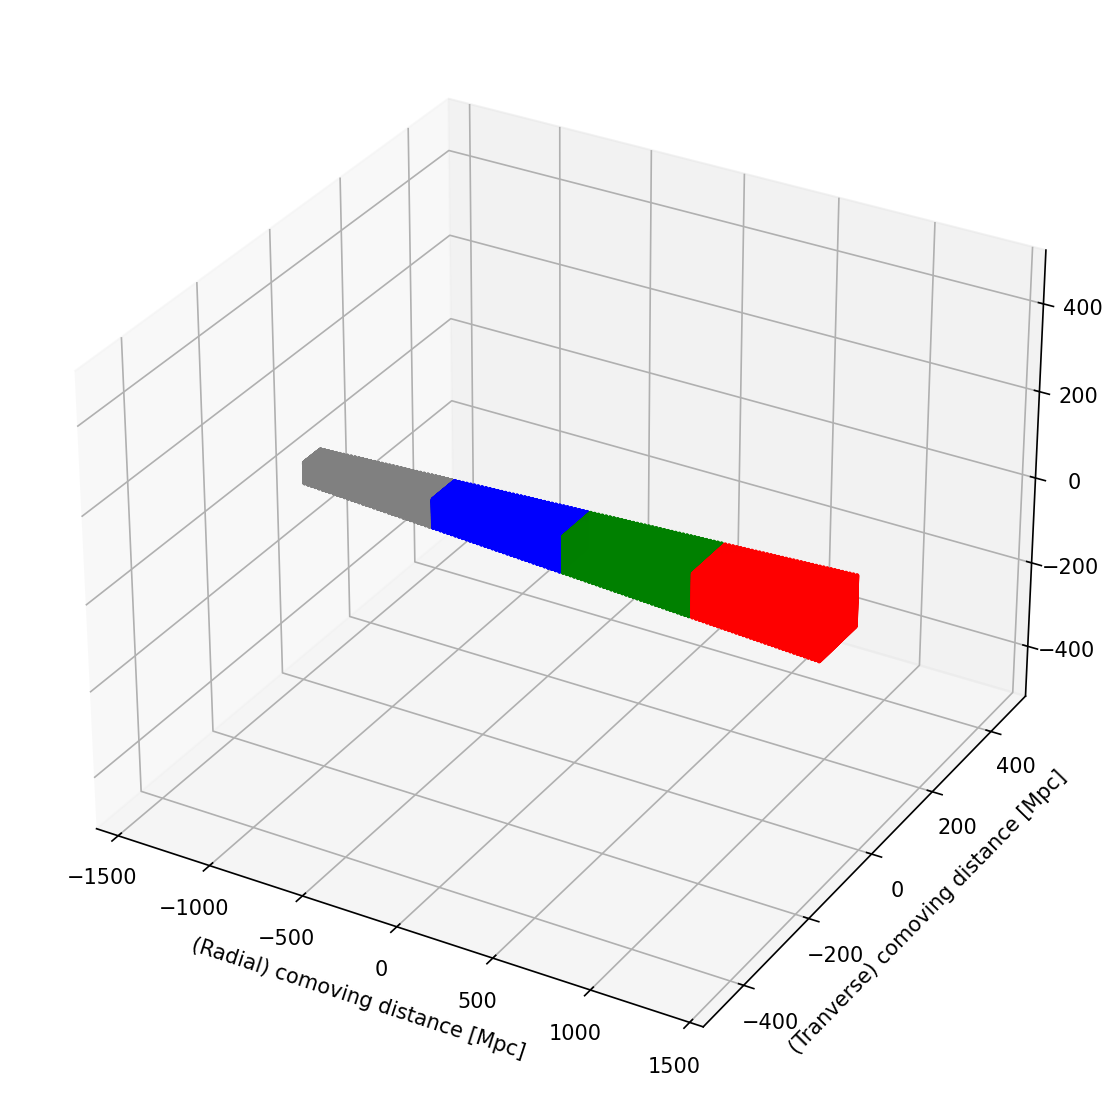

In [72]:
ind_bins = np.array_split(z_index, 4)
# 5. Plot
BS=10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 
fig = plt.figure(figsize=(7.5,7.5), dpi=150)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel("(Radial) comoving distance [Mpc]")
ax.set_ylabel("(Tranverse) comoving distance [Mpc]")
ax.set_ylim([-500, 500])  # Example limits for y-axis
ax.set_zlim([-500, 500])  # Example limits for z-axis

for ibin, c in zip(ind_bins, ('r','g','b','gray')):

    #2. Use broadcasting shapes directly:
    X = x[ibin, None, :]  
    Y = y[ibin, :, None]  
    Z = z[ibin,None,None] 

    # 3. Compute R using broadcasting
    R = np.sqrt(Z**2+X**2+Y**2)

    # 4. Flatten all to 1D arrays of same length
    xv = np.broadcast_to(X, R.shape).ravel()
    yv = np.broadcast_to(Y, R.shape).ravel()
    zv = np.broadcast_to(Z, R.shape).ravel()
    rv = R.ravel()

    sc = ax.scatter(zv, xv, yv, color=c, s=1, )
fig.tight_layout()


In [73]:
def make_bintab(k, delta_k_min, dkk = 0, delta_k_max=0, ):
    kmax      = k[1]
    kmin      = k[0]
    if(dkk == 0): 
        bintab = np.arange(kmin, kmax, delta_k_min )
        bin_width = np.ones(len(bintab)-1) * delta_k_min
    else:
        k1 = kmin
        delta_k = 0 
        bintab = []
        bintab.append(kmin)
        bin_width = []
        while(k1 + delta_k <= kmax):
            delta_k = np.minimum( np.maximum(k1*dkk, delta_k_min) , (kmax - k1) )
            if(delta_k_max != 0): 
                delta_k = np.minimum(delta_k, delta_k_max)
            k1 = k1 +  delta_k
            bintab.append(k1)
            bin_width.append(delta_k)
        bintab = np.asarray(bintab) 
    if( bintab.max() <= kmax):
        bintab[-1]    = kmax
        bin_width[-1] = bintab[-1]-bintab[-2]
    #bintab = np.insert(bintab,0,0)
    return bintab  , bin_width 

/tmp/ipykernel_15886/863301196.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


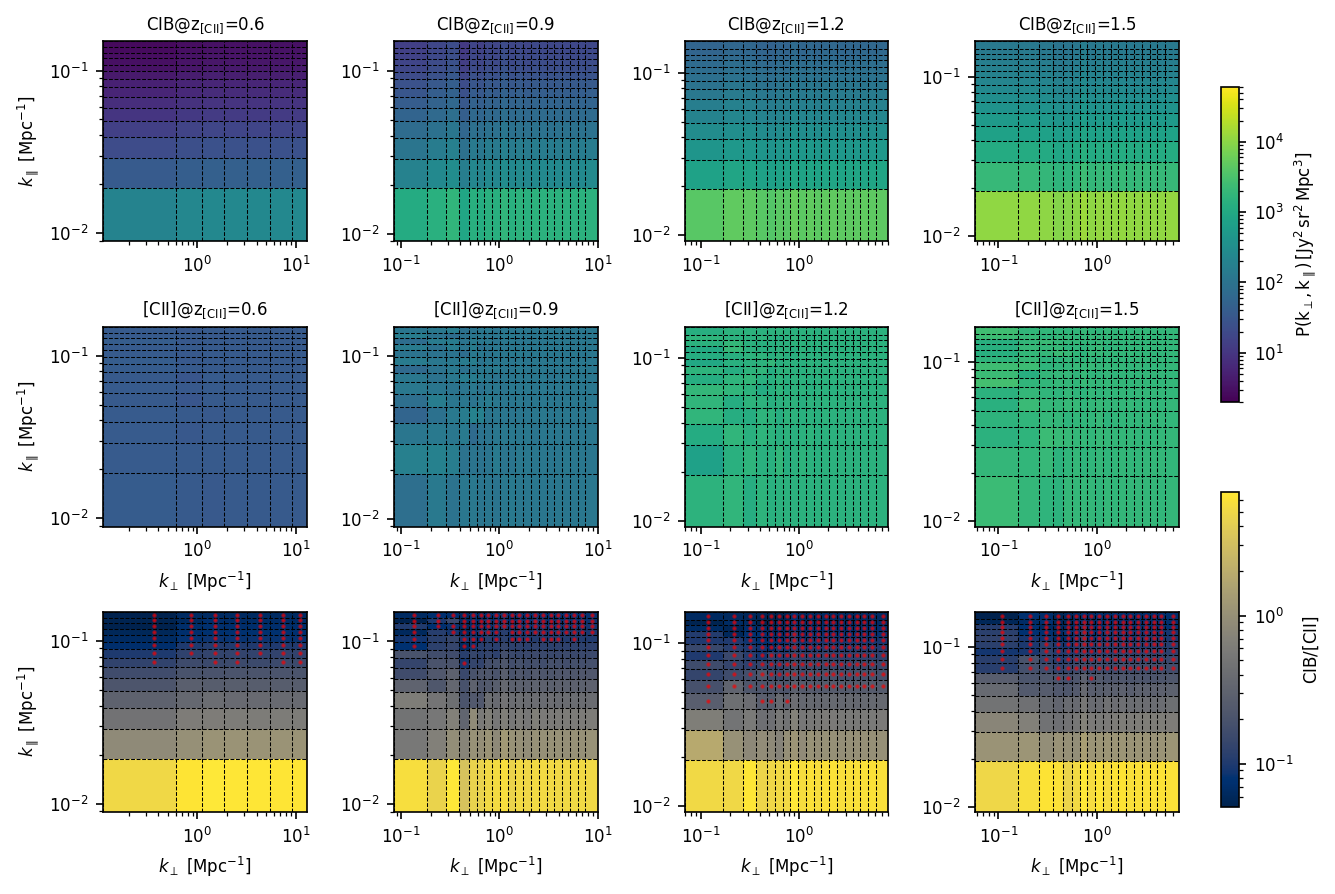

In [74]:
BS=8; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 
fig, axs = plt.subplots(3,4,figsize=(4*2,6), dpi=150)

for j, (ibin, c) in enumerate(zip(reversed(ind_bins), ('r','g','b','gray'))):

    res_Mpc = Delta_Dc[ibin].mean()*len_pix[ibin].mean()**2

    #2. Use broadcasting shapes directly:
    X = x[ibin, None, :]  
    Y = y[ibin, :, None]  
    Z = z[ibin,None,None]     
    
    # 3. Compute R using broadcasting (shape: 30×20×25)
    R = np.sqrt(Z**2+X**2+Y**2)

    # 4. Flatten all to 1D arrays of same length
    xv = np.broadcast_to(X, R.shape).ravel()
    yv = np.broadcast_to(Y, R.shape).ravel()
    zv = np.broadcast_to(Z, R.shape).ravel()
    rv = R.ravel()

    normpk = res_Mpc**3 / (R.shape[0] * R.shape[1] * R.shape[2])


    w_freq = 2*np.pi*np.fft.fftfreq(N_DEC, d=len_pix[ibin].mean())
    v_freq = 2*np.pi*np.fft.fftfreq(N_RA, d=len_pix[ibin].mean())
    u_freq = 2*np.pi*np.fft.fftfreq(len(ibin), d= Delta_Dc[ibin].mean())

    k_sphere = np.sqrt( (w_freq[:,None]**2+v_freq[None,:]**2) + u_freq[:,None,None]**2)
    k_transv = np.sqrt( w_freq[:,None,None]**2 + v_freq[None,:,None]**2)
    k_transv_3d = np.zeros(k_sphere.shape)
    k_transv_3d[:,:,:] = k_transv[:,:,0][np.newaxis,:,:]      
    k_z = np.sqrt( u_freq**2 )     
    k_z_3d = np.zeros(k_sphere.shape)
    k_z_3d[:,:,:] = k_z[:,np.newaxis, np.newaxis]  


    kperp_flat = k_transv_3d.flatten()
    kpar_flat = k_z_3d.flatten()

    #kperp_edges = np.logspace(np.log10(kperp_flat[kperp_flat>0].min()), np.log10(kperp_flat.max()), 15)
    #kpar_edges = np.logspace(np.log10(kpar_flat[kpar_flat>0].min()), np.log10(kpar_flat.max()), 7)
    kperp_edges, _ =  make_bintab( (kperp_flat[kperp_flat>0].min(), kperp_flat.max()), 0.1, dkk = 0.2, )
    kpar_edges, _ =  make_bintab( (kpar_flat[kpar_flat>0].min(), kpar_flat.max()), 0.01, dkk = 0.06,)
    if(j==0): kperp_edges, _ =  make_bintab( (kperp_flat[kperp_flat>0].min(), kperp_flat.max()), 0.5, dkk = 0.7, )



    # 5b. Compute number of modes per bin
    Nmodes, _, _ = np.histogram2d(
        kpar_flat, kperp_flat,
        bins=[kpar_edges, kperp_edges]
    )

     
    for i, (subcube,species) in enumerate(zip((subcube_cont, subcube_cii), ('CIB', '[CII]'))):

        pow_sqr = np.absolute(np.fft.fftn(subcube[ibin,:,:])**2 * normpk )

        # 1. Flatten everything
        pow_flat = pow_sqr.flatten()

        # 5a. Compute total power per (kpar, kperp) bin
        P2D_sum, kpar_edges_out, kperp_edges_out = np.histogram2d(
            kpar_flat, kperp_flat,
            bins=[kpar_edges, kperp_edges],
            weights=pow_flat
        )

        with np.errstate(divide='ignore', invalid='ignore'):
            P2D_avg = np.where(Nmodes > 0, P2D_sum / Nmodes, 0)
        
        # 2. Plot using pcolormesh (requires edges)
        pcm = axs[i,j].pcolormesh(kperp_edges_out, kpar_edges_out, P2D_avg, 
                            norm=LogNorm(vmin=2, vmax = 6e4), #vmin=np.nanmin(P2D_avg[P2D_avg>0]), vmax=np.nanmax(P2D_avg)),
                            cmap='viridis', shading='auto')
            
        # 3. Set axes to log scale
        axs[i,j].set_xscale('log')
        axs[i,j].set_yscale('log')

        # 4. Label axes
        axs[2,j].set_xlabel(r'$k_\perp$ [Mpc$^{-1}$]')
        axs[i,0].set_ylabel(r'$k_\parallel$ [Mpc$^{-1}$]')
        axs[2,0].set_ylabel(r'$k_\parallel$ [Mpc$^{-1}$]')
        axs[i,j].set_title(f'{species}@'+'$\\rm z_{[CII]}$'+f'={zcii[ibin].mean():.1f}')

        # Add vertical bin edges (k_perp)
        for kx in kperp_edges:
            axs[i,j].axvline(x=kx, color='k', linestyle='--', linewidth=0.5)

        # Add horizontal bin edges (k_par)
        for ky in kpar_edges:
            axs[i,j].axhline(y=ky, color='k', linestyle='--', linewidth=0.5)

        if(species=='CIB'): P2D_saved = P2D_avg
        #fig.colorbar(pcm, ax=axs[i,j], label=r'$\rm P(k_\perp, k_\parallel)\,[\mathrm{Jy}^2\,\mathrm{sr}^2\,\mathrm{Mpc}^3]$')

    #--
    # 2. Plot using pcolormesh (requires edges)
    if('CII' in species): 
        pcm_ratio = axs[-1,j].pcolormesh(kperp_edges_out, kpar_edges_out, P2D_saved/P2D_avg, 
            norm=LogNorm(), #vmin=np.nanmin(P2D_avg[P2D_avg>0]), vmax=np.nanmax(P2D_avg)),
            cmap='cividis', shading='auto')
        
        # Add vertical bin edges (k_perp)
        for kx in kperp_edges:
            axs[-1,j].axvline(x=kx, color='k', linestyle='--', linewidth=0.5)

        # Add horizontal bin edges (k_par)
        for ky in kpar_edges:
            axs[-1,j].axhline(y=ky, color='k', linestyle='--', linewidth=0.5)

        # Compute ratio mask where value < 0.2
        ratio_data = P2D_saved / P2D_avg
        mask_low = ratio_data < 0.2

        kx_centers = 0.5 * (kperp_edges_out[:-1] + kperp_edges_out[1:])
        ky_centers = 0.5 * (kpar_edges_out[:-1] + kpar_edges_out[1:])

        # Create 2D meshgrid of centers
        KXc, KYc = np.meshgrid(kx_centers, ky_centers)

        # mask of where ratio < 0.2
        mask_low = (P2D_saved / P2D_avg) < 0.2

        # Plot red dots at centers where mask is True
        axs[-1, j].scatter(KXc[mask_low], KYc[mask_low], color='red', s=5, marker='.', zorder=5, alpha=0.5)

                
    # 3. Set axes to log scale
    axs[i,j].set_xscale('log')
    axs[i,j].set_yscale('log')
        # 3. Set axes to log scale
    axs[2,j].set_xscale('log')
    axs[2,j].set_yscale('log')

    # 4. Label axes
    axs[1,j].set_xlabel(r'$k_\perp$ [Mpc$^{-1}$]')


# First colorbar: VIRIDIS (top right)
cax1 = fig.add_axes([1.02, 0.55, 0.015, 0.35])  # [left, bottom, width, height]
cbar1 = fig.colorbar(pcm, cax=cax1)
cbar1.set_label(r'$\rm P(k_\perp, k_\parallel)\, [\mathrm{Jy}^2\,\mathrm{sr}^2\,\mathrm{Mpc}^3]$')

# Second colorbar: CIVIDIS (bottom right)
cax2 = fig.add_axes([1.02, 0.1, 0.015, 0.35])   # same width, shifted down
cbar2 = fig.colorbar(pcm_ratio, cax=cax2)
cbar2.set_label(r'$\mathrm{CIB} / [\mathrm{CII}]$')

fig.tight_layout()


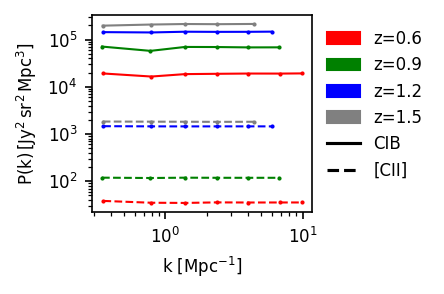

In [75]:
BS=8; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); 
fig, axs = plt.subplots(figsize=(3,2), dpi=150)
axa = axs
patchs = []

for j, (ibin, c) in enumerate(zip(reversed(ind_bins), ('r','g','b','gray'))):

    res_Mpc = Delta_Dc[ibin].mean()*len_pix[ibin].mean()**2

    patch = mpatches.Patch(color=c, label= f"z={zcii[ibin].mean():.1f}"); patchs.append(patch)


    #2. Use broadcasting shapes directly:
    X = x[ibin, None, :]  
    Y = y[ibin, :, None]  
    Z = z[ibin,None,None] 

    # 3. Compute R using broadcasting (shape: 30×20×25)
    R = np.sqrt(Z**2+X**2+Y**2)

    # 4. Flatten all to 1D arrays of same length
    xv = np.broadcast_to(X, R.shape).ravel()
    yv = np.broadcast_to(Y, R.shape).ravel()
    zv = np.broadcast_to(Z, R.shape).ravel()
    rv = R.ravel()

    normpk = res_Mpc**3 / (R.shape[0] * R.shape[1] * R.shape[2])

    w_freq = 2*np.pi*np.fft.fftfreq(N_DEC, d=len_pix[ibin].mean())
    v_freq = 2*np.pi*np.fft.fftfreq(N_RA, d=len_pix[ibin].mean())
    u_freq = 2*np.pi*np.fft.fftfreq(len(ibin), d= Delta_Dc[ibin].mean())

    k_sphere = np.sqrt( (w_freq[:,None]**2+v_freq[None,:]**2) + u_freq[:,None,None]**2)
    ksphere_flat = k_sphere.flatten()

    #kperp_edges = np.logspace(np.log10(kperp_flat[kperp_flat>0].min()), np.log10(kperp_flat.max()), 15)
    #kpar_edges = np.logspace(np.log10(kpar_flat[kpar_flat>0].min()), np.log10(kpar_flat.max()), 7)
    k_edges, _ =  make_bintab( (k_sphere[k_sphere>0].min(), k_sphere.max()), 0.5, dkk = 0.7, )


    # 5b. Compute number of modes per bin
    Nmodes, _ = np.histogram( ksphere_flat, bins=k_edges)

    for i, (subcube,species, ls) in enumerate(zip((subcube_cont, subcube_cii), ('CIB', '[CII]'),('-', '--'))):

        if(j==3): patch = mlines.Line2D([], [], color='k', linestyle=ls,  label=species); patchs.append(patch)

        pow_sqr = np.absolute(np.fft.fftn(subcube[ibin,:,:])**2 * normpk )

        # 1. Flatten everything
        pow_flat = pow_sqr.flatten()
        #kpar_edges = np.linspace(kpar_flat[kpar_flat>0].min(), kpar_flat.max(), 10)

        # 5a. Compute total power per (kpar, kperp) bin
        P2D_sum, _ = np.histogram(ksphere_flat, bins=k_edges, weights=pow_flat)
        k_out, _ = np.histogram(ksphere_flat, bins=k_edges, weights=ksphere_flat)

        with np.errstate(divide='ignore', invalid='ignore'):
            P2D_avg = np.where(Nmodes > 0, P2D_sum / Nmodes, 0)
            k_out  = np.where(Nmodes > 0, k_out / Nmodes, 0)
        
        # 2. Plot using pcolormesh (requires edges)
        axa.loglog(k_out, P2D_avg, 'o', c=c, ls=ls, markersize=1, linewidth=1)
        if(j==0): axb.loglog(k_out, '-o',c=c, markersize=1, linewidth=1)
            
        # 3. Set axes to log scale
        axa.set_xscale('log')
        axa.set_yscale('log')

        # 4. Label axes
        axa.set_ylabel(r'$\rm P(k)\, [\mathrm{Jy}^2\,\mathrm{sr}^2\,\mathrm{Mpc}^3]$')
        axa.set_xlabel('k [$\\rm Mpc^{-1}$]')

axa.legend(handles=patchs, bbox_to_anchor = (1,1), framealpha=0)

fig.tight_layout()